In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from ucimlrepo import fetch_ucirepo 

import gudhi

from TopoMapCut import TopoMapCutInv

2024-03-13 16:35:38.943799: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 16:35:38.985089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 16:35:38.985125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 16:35:38.986473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 16:35:38.993845: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 16:35:38.994371: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
def plot_persistance_diagram(X):
    rips_original = gudhi.RipsComplex(points=X.to_numpy())
    st_original = rips_original.create_simplex_tree(max_dimension=1)

    diag_original = st_original.persistence(min_persistence=0)

    # Create image
    fig, axs = plt.subplots(1, 1, figsize=(4, 4))

    gudhi.plot_persistence_diagram(diag_original, axes=axs)
    axs.set_title('Persistance Diagram')

    return fig

def plot_persistance_diagrams_projection(X, proj, y, y_column='class'):
    rips_original = gudhi.RipsComplex(points=X.to_numpy())
    st_original = rips_original.create_simplex_tree(max_dimension=1)

    rips_proj = gudhi.RipsComplex(points=proj)
    st_projection = rips_proj.create_simplex_tree(max_dimension=1)

    diag_original = st_original.persistence(min_persistence=0)
    diag_proj = st_projection.persistence(min_persistence=0)

    I_original = st_original.persistence_intervals_in_dimension(0)
    I_proj = st_projection.persistence_intervals_in_dimension(0)

    bt_blobs = gudhi.bottleneck_distance(I_original, I_proj)
    print(f"Bottleneck distance: {bt_blobs:.10f}")    

    # Create image
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    gudhi.plot_persistence_diagram(diag_original, axes=axs[0])
    axs[0].set_title('Persistance - Original Points')

    gudhi.plot_persistence_diagram(diag_proj, axes=axs[1])
    axs[1].set_title('Persistance - Projections')

    colors = [px.colors.qualitative.D3[i] for i in range(10)]

    i = 0
    for cluster in y[y_column].unique():
        i_cluster = list(y[y[y_column]==cluster].index)
        axs[2].scatter(proj[i_cluster,0], proj[i_cluster,1],
                c=colors[i], s=5)
        i += 1
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    axs[2].set_title('Projection')
    
    fig.suptitle('Persistence diagrams and Projection')
    fig.tight_layout()
    
    return fig

def plot_proj_max_comps(X, y, y_column, max_comps,
                        proj_method='tsne'):
    
    colors = [px.colors.qualitative.D3[i] for i in range(10)]
    
    projs = []

    for d in max_comps:
        topocut = TopoMapCutInv(X.to_numpy(),
                                max_components=d,
                                proj_method=proj_method)
        projs.append(topocut.run())

    y_column = 'class'
    n_plots = len(max_comps)
    fig, axs = plt.subplots(1, n_plots, figsize=(n_plots*4, 4))

    for d in range(n_plots):
        i = 0
        for cluster in y[y_column].unique():
            i_cluster = list(y[y[y_column]==cluster].index)
            axs[d].scatter(projs[d][i_cluster,0], projs[d][i_cluster,1],
                    c=colors[i], s=5)
            i += 1
            
        axs[d].set_xticks([])
        axs[d].set_yticks([])
        axs[d].set_title(f'Max components = {max_comps[d]}')

    fig.suptitle('Projection with different max_components')
    plt.tight_layout()

    return fig

## Iris

In [3]:
# fetch dataset 
iris = fetch_ucirepo(id=53) 
  
# data (as pandas dataframes) 
X = iris.data.features 
y = iris.data.targets 

/home/user/anaconda3/envs/topomap/lib/python3.11/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


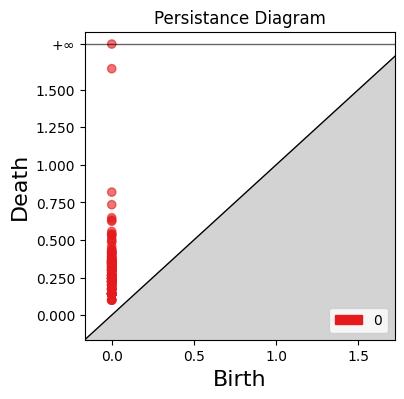

In [4]:
plot_persistance_diagram(X)
plt.show()

In [5]:
topocut_iris = TopoMapCutInv(X.to_numpy(), 
                            max_components=100,
                            proj_method='tsne')
proj_iris = topocut_iris.run()
print(f'Number of components: {len(topocut_iris.subsets)}')

[INFO] Max components hit. # components: 100 | Max_components: 100
Number of components: 100


Bottleneck distance: 1.8043767992


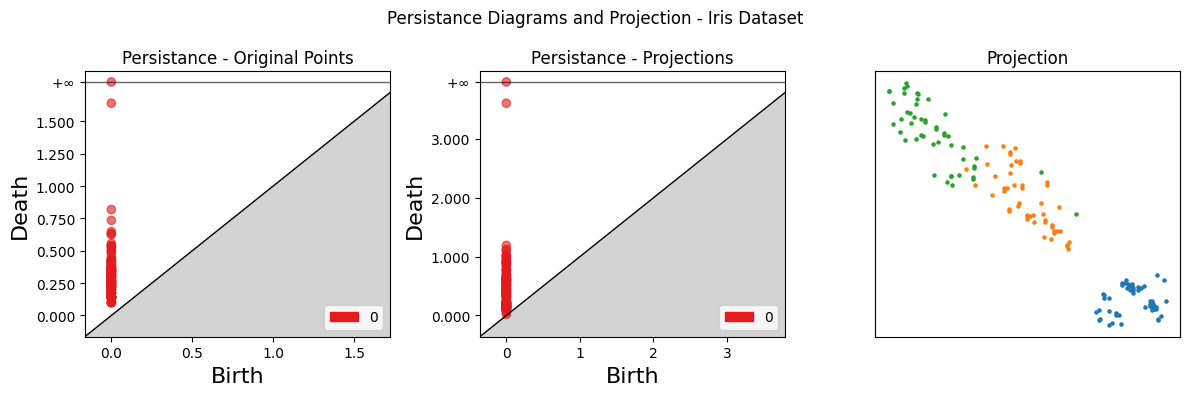

In [6]:
fig_iris = plot_persistance_diagrams_projection(X, proj_iris, y)
fig_iris.suptitle('Persistance Diagrams and Projection - Iris Dataset')
plt.show()

[INFO] Max components hit. # components: 25 | Max_components: 25
[INFO] Max components hit. # components: 50 | Max_components: 50
[INFO] Max components hit. # components: 100 | Max_components: 100


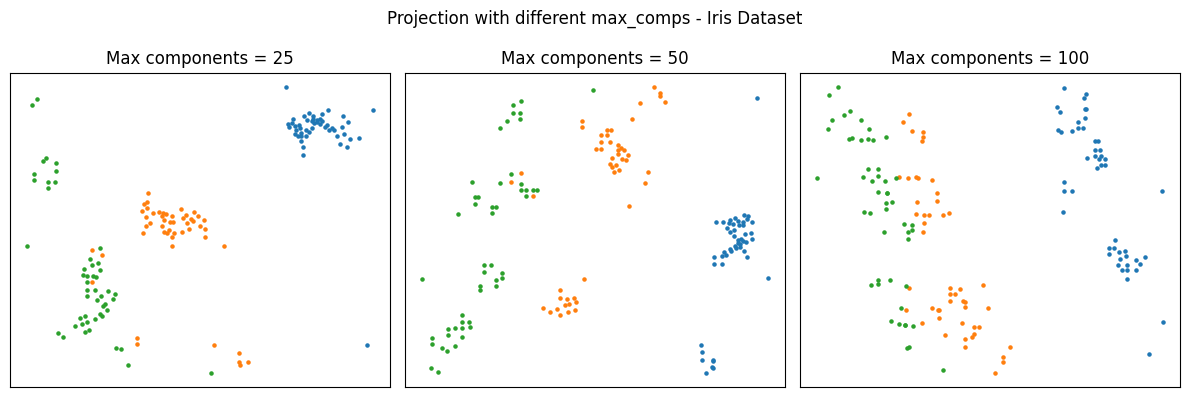

In [7]:
max_comps_iris = [25, 50, 100]
fig = plot_proj_max_comps(X, y, 'class', max_comps_iris, proj_method='pca')
fig.suptitle('Projection with different max_comps - Iris Dataset')
plt.show()

## Seeds

In [8]:
data_seeds = pd.read_csv('data/UCI/seeds/seeds_dataset.txt', sep='\t',
                         header=None,
                         names=['x1','x2','x3','x4','x5','x6','x7','class'])

X_seeds = data_seeds.copy().drop(['class'], axis=1)
y_seeds = data_seeds[['class']]

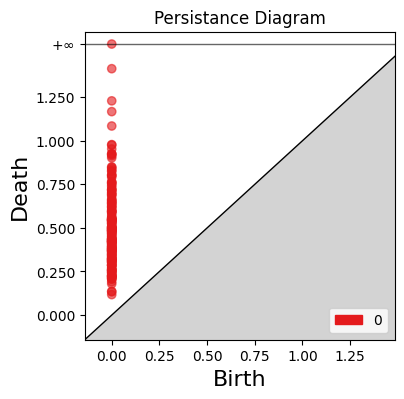

In [9]:
plot_persistance_diagram(X_seeds)
plt.show()

In [10]:
max_dist = 1.0

topocut_seeds = TopoMapCutInv(X_seeds.to_numpy(),
                              max_components=100,
                              proj_method='tsne')
proj_seeds = topocut_seeds.run()
print(f'Number of components: {len(topocut_seeds.subsets)}')

[INFO] Max components hit. # components: 100 | Max_components: 100
Number of components: 100


Bottleneck distance: 2.0366458884


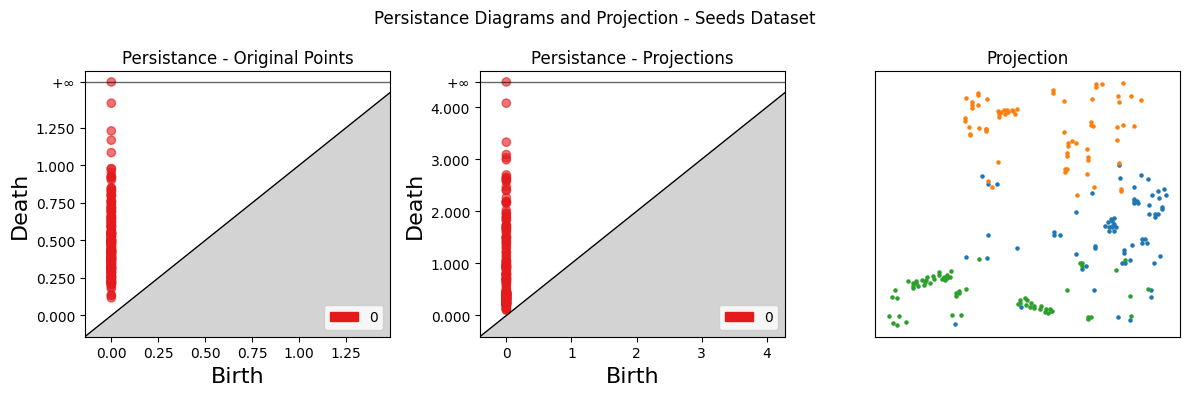

In [11]:
fig_seeds = plot_persistance_diagrams_projection(X_seeds, proj_seeds, y_seeds)
fig_seeds.suptitle('Persistance Diagrams and Projection - Seeds Dataset')
plt.show()

[INFO] Max components hit. # components: 25 | Max_components: 25
[INFO] Max components hit. # components: 50 | Max_components: 50
[INFO] Max components hit. # components: 100 | Max_components: 100


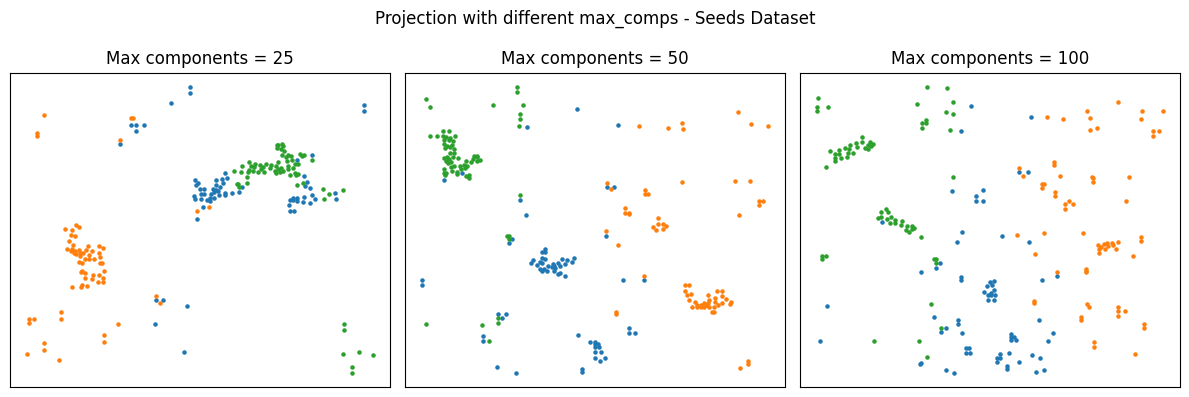

In [12]:
max_comps_seeds = [25, 50, 100]
fig = plot_proj_max_comps(X_seeds, y_seeds, 'class', max_comps_seeds, proj_method='pca')
fig.suptitle('Projection with different max_comps - Seeds Dataset')
plt.show()

## Cancer

In [13]:
# fetch dataset 
breast_cancer_wisconsin_original = fetch_ucirepo(id=15) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_original.data.features 
y = breast_cancer_wisconsin_original.data.targets 

y_column = 'Class'

In [14]:
y = y[X.notna().all(axis=1)]
X = X[X.notna().all(axis=1)]

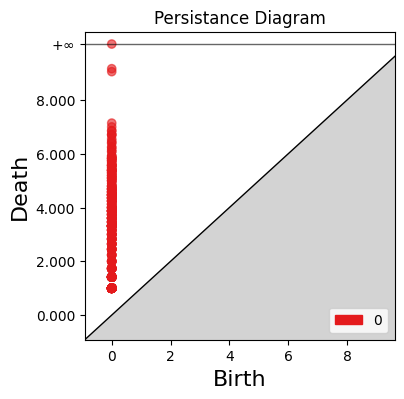

In [15]:
plot_persistance_diagram(X)
plt.show()

In [16]:
max_comps = 50

topocut_cancer = TopoMapCutInv(X.to_numpy(), proj_method='pca',
                               max_components=max_comps)
proj_cancer = topocut_cancer.run()

[INFO] Max components hit. # components: 50 | Max_components: 50


In [18]:
proj_cancer.shape

(683, 2)

In [20]:
y.shape

(683, 1)

Bottleneck distance: 35.3230700346


IndexError: index 683 is out of bounds for axis 0 with size 683

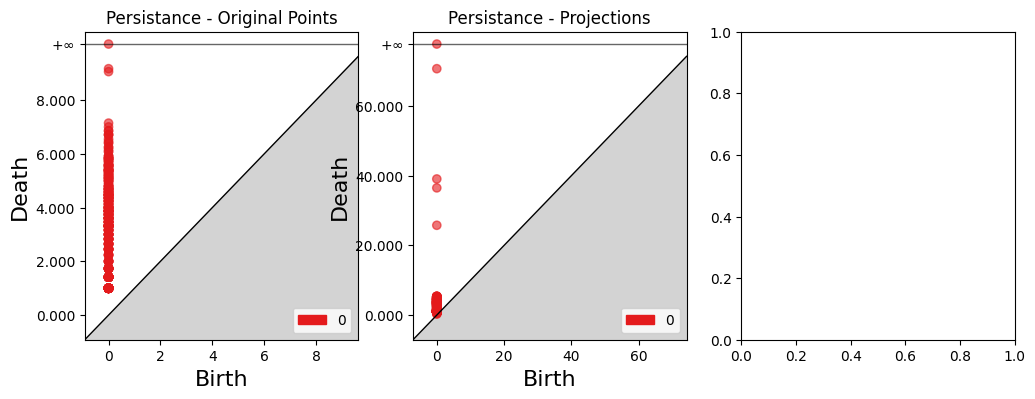

In [17]:
fig_cancer = plot_persistance_diagrams_projection(X, proj_cancer, y, y_column=y_column)
fig_cancer.suptitle('Persistance Diagrams and Projection - Cancer Dataset')
plt.show()

## MFeat

In [21]:
data_mfeat = pd.read_csv('data/UCI/multiple+features/mfeat-kar', sep='\s+',
                         header=None,
                         names=['x'+str(i) for i in range(1,65)])
data_mfeat['class'] = 0
for i, row in data_mfeat.iterrows():
    data_mfeat.loc[i,'class'] = i//200

X_mfeat = data_mfeat.drop(['class'], axis=1)
y_mfeat = data_mfeat[['class']]

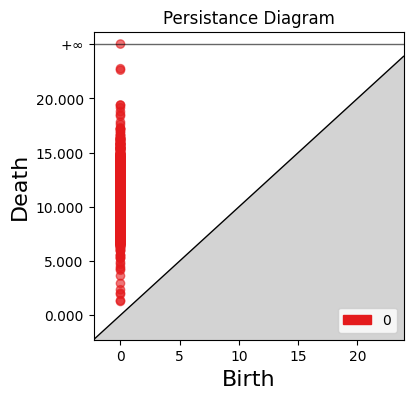

In [22]:
plot_persistance_diagram(X_mfeat)
plt.show()

In [23]:
max_comps = 100

topocut_mfeat = TopoMapCutInv(X_mfeat.to_numpy(),
                              max_components=max_comps
                            )
proj_mfeat = topocut_mfeat.run()

[INFO] Max components hit. # components: 100 | Max_components: 100


Bottleneck distance: 269.5709532765


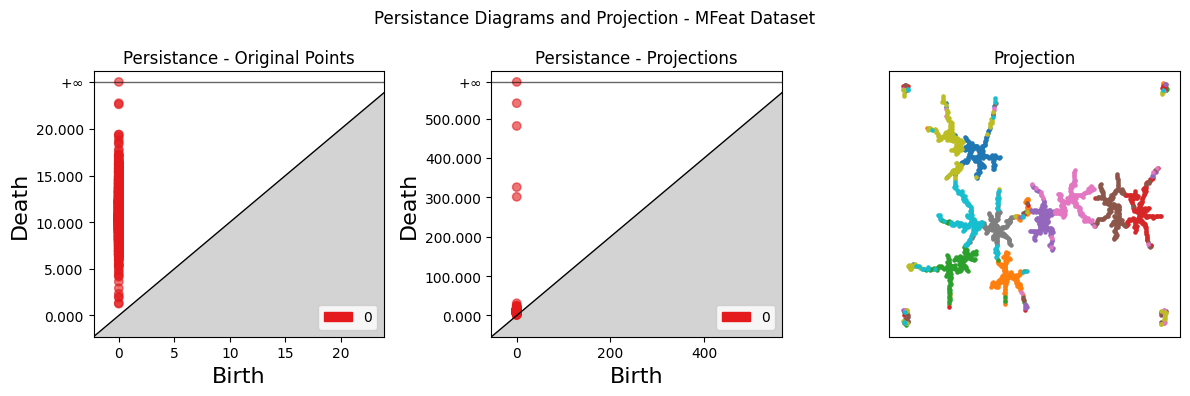

In [24]:
fig_mfeat = plot_persistance_diagrams_projection(X_mfeat, proj_mfeat, y_mfeat)
fig_mfeat.suptitle('Persistance Diagrams and Projection - MFeat Dataset')
plt.show()

[INFO] Max components hit. # components: 100 | Max_components: 100
[INFO] Max components hit. # components: 200 | Max_components: 200
[INFO] Max components hit. # components: 300 | Max_components: 300
[INFO] Max components hit. # components: 400 | Max_components: 400


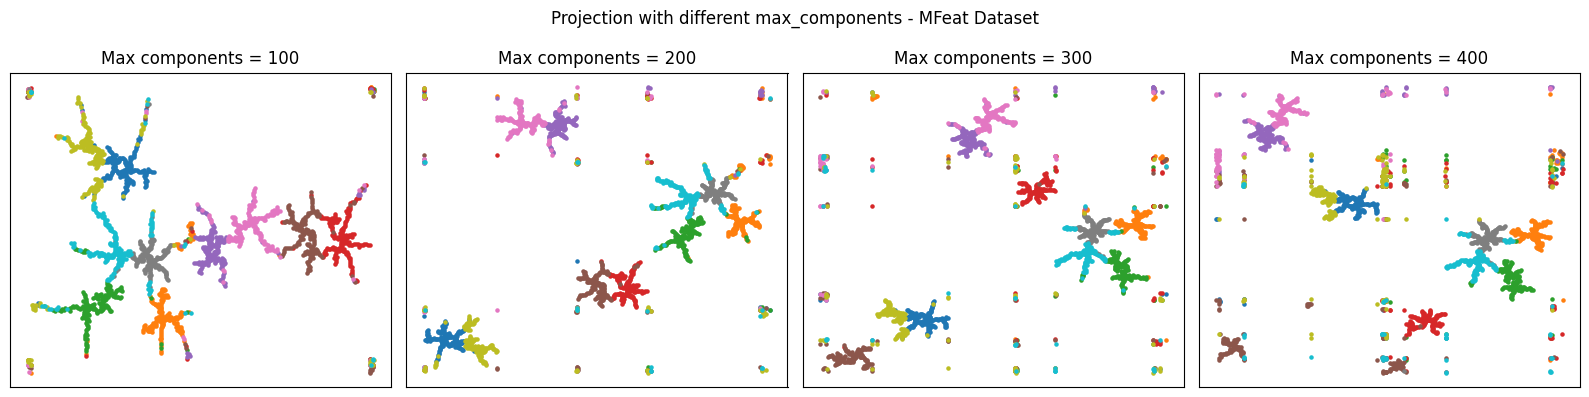

In [26]:
max_comps_mfeat = [100, 200, 300, 400]
fig = plot_proj_max_comps(X_mfeat, y_mfeat, 'class', max_comps_mfeat, proj_method='pca')
fig.suptitle('Projection with different max_components - MFeat Dataset')
plt.show()